# Stat222 HW4

Seokjun Choi

*All code blocks are Python scripts.*
*Used Python version is 3.10.5 for Windows, 64 bits.*

*python script: https://github.com/letsjdosth/bnp/blob/main/hw4.py*


From R, I saved the `airquality` dataset after deleting NAs.

According to the help file in R's `dataset::airquality`, the set has 153(111, after discarding NAs) observations on 6 variables.
- [,1]	Ozone	numeric	Ozone (ppb)
- [,2]	Solar.R	numeric	Solar R (lang)
- [,3]	Wind	numeric	Wind (mph)
- [,4]	Temp	numeric	Temperature (degrees F)
- [,5]	Month	numeric	Month (1--12)
- [,6]	Day	numeric	Day of month (1--31)

And,

- Ozone: Mean ozone in parts per billion from 1300 to 1500 hours at Roosevelt Island
- Solar.R: Solar radiation in Langleys in the frequency band 4000–7700 Angstroms from 0800 to 1200 hours at Central Park
- Wind: Average wind speed in miles per hour at 0700 and 1000 hours at LaGuardia Airport
- Temp: Maximum daily temperature in degrees Fahrenheit at La Guardia Airport.

<img src="./hw4_figures/pairs.png" width=500>

We can see nonlinear relationships with some pairs.


Let me load libraries and data.

In [21]:
import csv
from math import log
from random import seed, betavariate, gammavariate, choices, randint

import numpy as np
from scipy.stats import multivariate_normal as sp_mvn
from scipy.stats import invwishart as sp_inv_wishart
import matplotlib.pyplot as plt

from pyBayes.MCMC_Core import MCMC_Gibbs, MCMC_Diag
from pyBayes.rv_gen_gamma import Sampler_InvWishart



data_airquality = []
#0     1       2    3
#Ozone Solar.R Wind Temp
with open("data/airquality_data.csv", "r", newline="") as csv_f:
    csv_reader = csv.reader(csv_f)
    next(csv_reader)
    for row in csv_reader:
        data_airquality.append((int(row[1]), int(row[2]), float(row[3]), int(row[4])))
# print(data_airquality)
# print(len(data_airquality)) #111
data_ozone = [z[0] for z in data_airquality]
data_solar_r = [z[1] for z in data_airquality]
data_wind = [z[2] for z in data_airquality]
data_temp = [z[3] for z in data_airquality]

## Fitting
*In this article, I report how I failed to get a good result and discuss why.* Fitting result is not good but shows some aspects of density regression models.

I implement the block-Gibbs sampler for density regression with the dataset.
The class `HW4DensityReg` is the key part of my block-Gibbs sampler.
Additional class `HW4DensityReg_Infer` works for inference processes, including posterior joint-sampler, posterior conditional sampler, and so on.

### Settings

**Note**

As I noted in the attached note, I had some issues with covariance mixing. 
It is a problem with my model specification or code with unknown bugs.
In this submitted document, I just commented out the part updating $\Sigma_l$ in the method `HW4DensityReg.full_conditional_sampler_mu_l_sigma_l`, but added some lines returning 'fixed $\Sigma_l$'. (Note that all lines starting with \# are a comment in Python's grammar.)
So, this document's result is NOT from a model allowing covariance mixing but from the mean-mixing-only model.
All hyperparameters related to the covariance-mixing defined in `HW4DensityReg.__init__` are not used. 

By canceling to commentate the part and deleting the part fixing $\Sigma_l$, we can run this script, allowing mixing $\Sigma_l$ with DP.
So far, I could not have had a nice fitting result. Always $\Sigma_l$s are inflated too much, yielding one-mixture-component fits. It gets a typical normal-InvWishart hierarchical model, making our inference less attractive.

Now, settings are, (where $I_4$ is the 4-by-4 identity matrix,)
- $N=30$, the truncation level for the stick-breaking process.
- $a_\alpha=b_\alpha=1$, hyperparameters for $p(\alpha)$, which is vague with mean 1.
- $m_\mu=(0,0,0,0)^T$ and $s_\mu = I_4*10$, the hyperparameters for $\mu_0$. By setting $s_\mu$ large, I hope it gets vague.
- $a_\tau = 10$ and $b_\tau = 10*I_4$. I want a prior not allowing a large variance for $\tau_0$.

And,
- (tentative) the fixed $\Sigma_l$ is $20*I_4$ for the third model setting.
- (Not applied) $\psi_2 = (v_0=3000, \Lambda_0=I_4)$, which are hyperparameters for the second model setting. Now, they are ignored. To prevent exploding $\Sigma_l$, we may need larger $v_0$.

In [22]:
class HW4DensityReg(MCMC_Gibbs):
    def __init__(self, initial, yx_data, N_truncation):
        self.MC_sample = [initial]
        self.yx_data = yx_data

        #samplers
        seed(20230614)
        np.random.seed(20230614)
        self.sampler_np = np.random.default_rng(20230614)
        self.sampler_invWishart = Sampler_InvWishart(20230614)

        #setting
        self.N = N_truncation
        self.nonsingular_adjust = 0.001

        #hyperparams
        self.hyper_v0 = 3000
        self.hyper_Lambda0 = np.eye(4)

        self.hyper_alpha_a = 1
        self.hyper_alpha_b = 1
        self.hyper_m_mu = np.zeros(4)
        self.hyper_s_mu = np.eye(4)*10
        self.hyper_tau0_a = 10
        self.hyper_tau0_b = np.eye(4)*10
    
    def sampler(self, **kwargs):
        last = self.MC_sample[-1]
        new = self.deep_copier(last)
        #update new
        new = self.full_conditional_sampler_mu_l_sigma_l(new)
        new = self.full_conditional_sampler_w_l(new)
        new = self.full_conditional_sampler_Li(new)
        new = self.full_conditional_sampler_mu0_tau0(new)
        new = self.full_conditional_sampler_alpha(new)
        self.MC_sample.append(new)
    
    def full_conditional_sampler_mu_l_sigma_l(self, last_param):
        # sample
        #  0                           1                2                3     4      5
        # [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
        new_sample = last_param #pointer
        
        inv_tau_0 = np.linalg.inv(last_param[4])
        prod_inv_tau_0_mu_0 = inv_tau_0 @ last_param[3]
        for j, (_, Sigma_l) in enumerate(last_param[0]):
            yx_list_j = []
            for yx_i, L_i in zip(self.yx_data, last_param[2]):
                if L_i==j:
                    yx_list_j.append(np.array(yx_i))

            #update mu_l
            if len(yx_list_j)==0:
                new_mu_l = self.sampler_np.multivariate_normal(last_param[3], last_param[4])
            else:
                inv_Sigma_l = np.linalg.inv(Sigma_l)
                mu_l_precision = inv_tau_0 + inv_Sigma_l*len(yx_list_j)
                mu_l_cov = np.linalg.inv(mu_l_precision)

                mu_l_mean = mu_l_cov @ (prod_inv_tau_0_mu_0 + inv_Sigma_l@np.sum(yx_list_j, axis=0))
                new_mu_l = self.sampler_np.multivariate_normal(mu_l_mean, mu_l_cov)

            ## update Sigma_l
            # if len(yx_list_j)== 0:
            #     # new_Sigma_l = self.sampler_invWishart.sampler_iter(1, self.hyper_v0, self.hyper_Lambda0, "inv")[0]
            #     new_Sigma_l = sp_inv_wishart.rvs(self.hyper_v0, self.hyper_Lambda0)
            # else:
            #     v = self.hyper_v0 + len(yx_list_j)
            #     lamb = self.hyper_Lambda0
            #     for yx in yx_list_j:
            #         lamb += np.outer(yx - new_mu_l, yx - new_mu_l)
            #     # new_Sigma_l = self.sampler_invWishart.sampler_iter(1, v, lamb, "inv")[0]
            #     new_Sigma_l = sp_inv_wishart.rvs(v, lamb)
                
            # if np.linalg.det(new_Sigma_l) == 0:
            #     new_Sigma_l += (np.eye(4)*self.nonsingular_adjust)
            
            ## fixed Sigma_l case:
            new_Sigma_l = np.eye(4)*20 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
            new_sample[0][j] = (new_mu_l, new_Sigma_l)
        return new_sample
    
    def _Li_counter(self, Li_vec):
        count_result = [0 for _ in range(self.N)]
        for l in Li_vec:
            count_result[l] += 1
        return count_result

    def full_conditional_sampler_w_l(self, last_param):
        # sample
        #  0                           1                2                3     4      5
        # [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
        new_sample = last_param #pointer
        new_w = []
        Li_counter = self._Li_counter(last_param[2])
        left_stick = 1
        for j in range(self.N-1):
            beta_al = 1 + Li_counter[j]
            beta_bl = last_param[5] + sum(Li_counter[(j+1):])
            Z_l = betavariate(beta_al, beta_bl)
            new_w_j = Z_l * left_stick
            new_w.append(new_w_j)
            left_stick *= (1-Z_l)
        
        w_N = 1.0-sum(new_w)
        if w_N <= 0:
            w_N = 1e-16
        new_w.append(w_N)
        
        assert len(new_w)==self.N
        new_sample[1] = new_w
        return new_sample
    
    def full_conditional_sampler_Li(self, last_param):
        # sample
        #  0                           1                2                3     4      5
        # [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
        new_sample = last_param #pointer
        for i, yx_i in enumerate(self.yx_data):
            weight_i = []
            for (mu_l, sigma_l), w_l in zip(last_param[0], last_param[1]):
                pdf_val = sp_mvn.pdf(yx_i, mu_l, sigma_l, allow_singular=True) #hmm
                weight = w_l * pdf_val
                weight_i.append(weight)
            new_Li = choices([k for k in range(self.N)], weights=weight_i)[0]
            new_sample[2][i] = new_Li
        return new_sample
    
    def full_conditional_sampler_mu0_tau0(self, last_param):
        # sample
        #  0                           1                2                3     4      5
        # [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
        
        new_sample = last_param #pointer
        
        #update mu0
        inv_tau_0 = np.linalg.inv(last_param[4])
        inv_s_mu = np.linalg.inv(self.hyper_s_mu)
        mu_0_precision = inv_s_mu + inv_tau_0*self.N
        mu_0_cov = np.linalg.inv(mu_0_precision)
        sum_mu_l = np.zeros(4)
        for mu_l, _ in last_param[0]:
            sum_mu_l += mu_l
        mu_0_mean = mu_0_cov @ (inv_s_mu@self.hyper_m_mu + inv_tau_0 @ sum_mu_l)
        new_mu0 = self.sampler_np.multivariate_normal(mu_0_mean, mu_0_cov)

        tau_0_v = self.hyper_tau0_a + self.N
        tau_0_lamb = self.hyper_tau0_b
        for mu_l, _ in last_param[0]:
            tau_0_lamb += np.outer(mu_l - new_mu0, mu_l - new_mu0)
            
        # new_tau0 = self.sampler_invWishart.sampler_iter(1, tau_0_v, tau_0_lamb, "inv")[0]
        new_tau0 = sp_inv_wishart.rvs(tau_0_v, tau_0_lamb)
        
        if np.linalg.det(new_tau0) == 0:
            new_tau0 += (np.eye(4)*self.nonsingular_adjust)
        
        new_sample[3] = new_mu0
        new_sample[4] = new_tau0
        # new_sample[4] = np.eye(4)*10

        return new_sample
    
    def full_conditional_sampler_alpha(self, last_param):
        # sample
        #  0                           1                2                3     4      5
        # [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
        new_sample = last_param #pointer
        
        w_N = last_param[1][-1]
        shape = 1/(self.hyper_alpha_b - log(w_N))
        new_alpha = gammavariate(self.N + self.hyper_alpha_a - 1, shape)
        new_sample[5] = new_alpha
        return new_sample

class HW4DensityReg_Infer:
    def __init__(self, yx_data, MC_sample) -> None:
        # sample
        #  0                           1                2                3     4      5
        # [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
        self.MC_sample = MC_sample
        self.yx_data = yx_data
        self.N = len(MC_sample[0][0])

    def _q_x(self, x, post_sample):
        q_weights = []
        for (mu_l, sigma_l), w_l in zip(post_sample[0], post_sample[1]):
            mu_l_x = mu_l[1:]
            sigma_l_x = sigma_l[1:, 1:]
            q_l = w_l * sp_mvn.pdf(x, mu_l_x, sigma_l_x)
            q_weights.append(q_l)
        return q_weights
    
    def _lambda_tau2(self, x, post_sample):
        lambda_tau2_tuples = []
        for (mu_l, sigma_l) in post_sample[0]:
            mu_y = mu_l[0]
            mu_x = mu_l[1:]
            sigma_yy = sigma_l[0,0]
            sigma_yx = sigma_l[0,1:]
            inv_sigma_xx = np.linalg.inv(sigma_l[1:,1:])
            lambda_l = mu_y + sigma_yx @ inv_sigma_xx @ (x - mu_x)
            tau2_l = sigma_yy - sigma_yx @ inv_sigma_xx @ np.transpose(sigma_yx)
            lambda_tau2_tuples.append((lambda_l, tau2_l))
        return lambda_tau2_tuples

    def y_given_x_G_rv_gen(self, x):
        #x in R3
        y_samples = []
        for post_sample in self.MC_sample:
            lambda_tau2_tuples = self._lambda_tau2(x, post_sample)
            qx = self._q_x(x, post_sample)
            
            chosen_l = choices([i for i in range(self.N)], weights=qx)[0]
            lambda_l, tau2_l = lambda_tau2_tuples[chosen_l]
            new_sample = sp_mvn.rvs(lambda_l, tau2_l)
            y_samples.append(new_sample)
        return y_samples
        
    def y_given_x_G_mean_quantile(self, x):
        samples = self.y_given_x_G_rv_gen(x)
        quant_est = np.quantile(samples, [0.025, 0.5, 0.975])
        mean_est = np.mean(samples)
        return mean_est, quant_est

    def yx_pair_joint_rv_gen(self):
        # sample
        #  0                           1                2                3     4      5
        # [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
        joint_samples = []
        for post_sample in self.MC_sample:
            chosen_l = choices([i for i in range(self.N)], weights=post_sample[1])[0]
            mu_l, sigma_l = post_sample[0][chosen_l]
            new_sample = sp_mvn.rvs(mu_l, sigma_l)
            joint_samples.append(new_sample)
        return joint_samples
    
    def yx_pair_joint_rv_gen_for_plot(self):
        joint_samples = self.yx_pair_joint_rv_gen()
        return (np.transpose(joint_samples)).tolist()


Now, I will generate 1,000 samples and cut the first 200 samples as a burn-in period.

In [23]:
seed(20230614)
np.random.seed(20230614)
# sample
#  0                           1                2                3     4      5
# [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
trunc_N = 30
initial = [[(data_airquality[i], np.eye(4)) for i in range(trunc_N)], 
        [1/trunc_N for _ in range(trunc_N)], 
        [i%trunc_N for i in range(len(data_airquality))], 
        [0,0,0,0],
        np.eye(4),
        10]
gibbs_inst = HW4DensityReg(initial, data_airquality, trunc_N)
gibbs_inst.generate_samples(1000, print_iter_cycle=50)
diag_inst = MCMC_Diag()
diag_inst.set_mc_sample_from_MCMC_instance(gibbs_inst)
# diag_inst.write_samples("hw4_samples")
diag_inst.set_variable_names(["mu_sigma", "w", "L", "mu0", "tau0", "alpha"])
diag_inst.burnin(200)


estimated running time:  6.0 min  34.89603042602539 sec
iteration 50 / 1000
iteration 100 / 1000
iteration 150 / 1000
iteration 200 / 1000
iteration 250 / 1000
iteration 300 / 1000
iteration 350 / 1000
iteration 400 / 1000
iteration 450 / 1000
iteration 500 / 1000
iteration 550 / 1000
iteration 600 / 1000
iteration 650 / 1000
iteration 700 / 1000


c:\Users\rtoru\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


iteration 750 / 1000
iteration 800 / 1000
iteration 850 / 1000
iteration 900 / 1000
iteration 950 / 1000
iteration 1000 / 1000  done! (elapsed time for execution:  6.0 min  37.20155096054077 sec)


The inverse-Wishart sampling is very unstable.
The overflow occurred at an inverse Wishart sample in a component without datapoint, so it had no effect and was removed after the next iteration.

### MCMC diagnosis

The fitting result is *not* perfect, but the imperfection is still interesting, giving some intuition to me.
So let me share the result.

I display traceplots to check MCMC convergence.

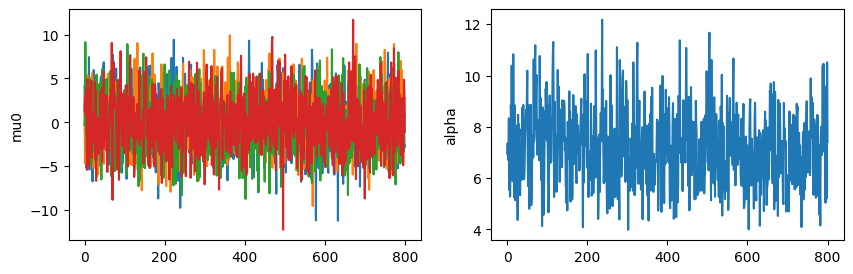

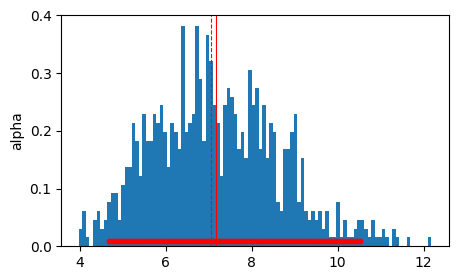

In [26]:
diag_inst.show_traceplot((1,2),[3,5])
diag_inst_alpha = MCMC_Diag()
alpha_list = [[a] for a in diag_inst.get_specific_dim_samples(5)]
diag_inst_alpha.set_mc_samples_from_list(alpha_list)
diag_inst_alpha.set_variable_names(['alpha'])
diag_inst_alpha.show_hist((1,1))


Because $mu_0$ is four-dimensional, there are four dimension-wise traces. All are near 0.
The mean and median(vertical solid and dotted lines on the histogram) are near 7 for $\alpha$.
So, in the posterior, the DP component's level of discreteness and variance seems high.

The next four figures are traceplots for $w_1,...,w_4$. Let me skip others.

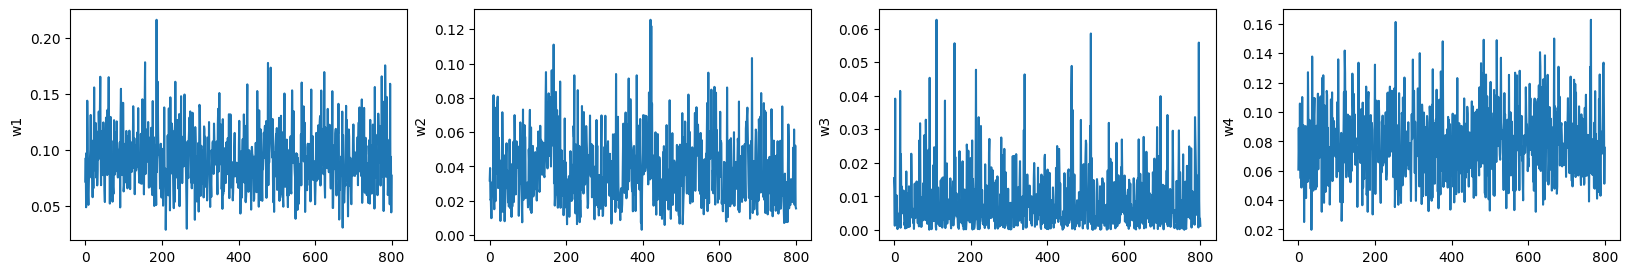

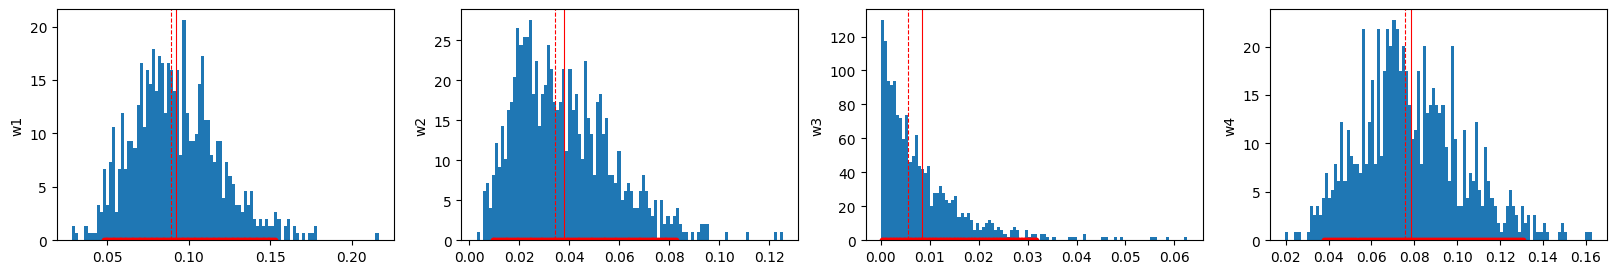

In [48]:
# sample
#  0                           1                2                3     4      5
# [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
diag_inst_w = MCMC_Diag()
diag_inst_w.set_mc_samples_from_list(diag_inst.get_specific_dim_samples(1))
diag_inst_w.set_variable_names(['w'+str(l) for l in range(1,trunc_N+1)])
diag_inst_w.show_traceplot((1,4), [0,1,2,3])
diag_inst_w.show_hist((1,4), [0,1,2,3])

Every traceplot seems fine.

Plus, I show traceplots for $L_i$.

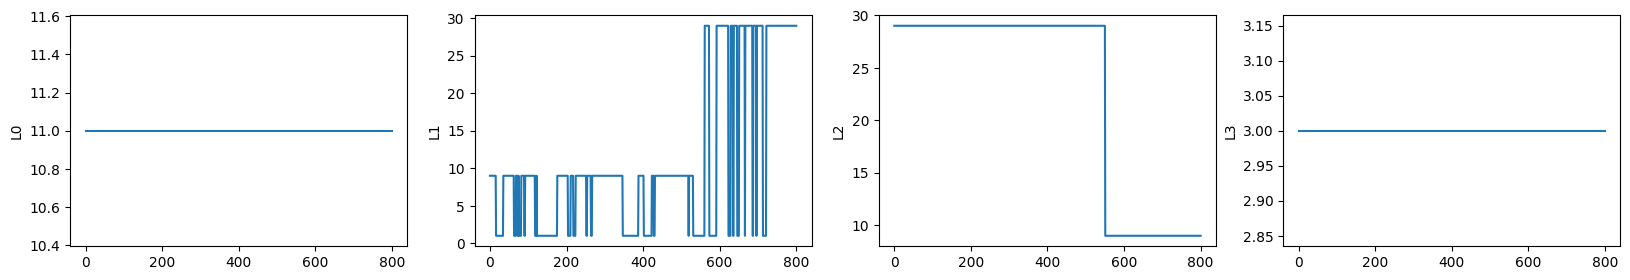

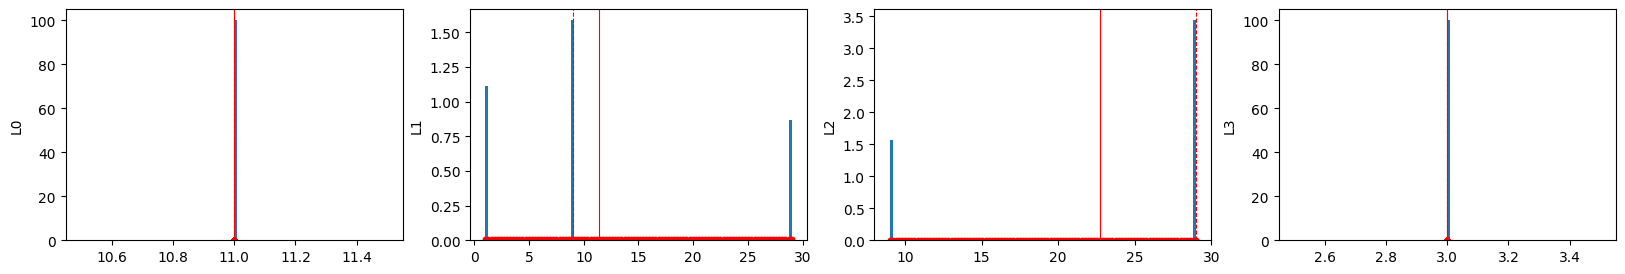

In [49]:
# sample
#  0                           1                2                3     4      5
# [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
diag_inst_L = MCMC_Diag()
diag_inst_L.set_mc_samples_from_list(diag_inst.get_specific_dim_samples(2))
diag_inst_L.set_variable_names(['L'+str(i) for i in range(len(data_airquality))])
diag_inst_L.show_traceplot((1,4), [0,1,2,3])
diag_inst_L.show_hist((1,4), [0,1,2,3])

The labels of clusters for $i$th data, $L_i$, do not move very well for whole iterations.
The bad MCMC mixing is because the fixed variance is not optimal so that the $g_0$ evaluated at each data point is dominated by only one component.
I will again discuss the specification of $\Sigma_l$ when watching the posterior joint distribution below.

Note that realized $L_i$ samples look like, for the last three posterior samples,

In [52]:
for smpl in diag_inst.MC_sample[-4:-1]:
    print(smpl[2]) #Li
    # print([x[0] for x in smpl[0]])
    # print([round(y,4) for y in smpl[1]]) #w1
    # print(smpl[0][smpl[2][0]])

[11, 29, 9, 3, 3, 5, 0, 12, 12, 12, 19, 3, 3, 19, 3, 26, 0, 3, 0, 5, 0, 17, 16, 12, 29, 15, 3, 9, 11, 12, 26, 1, 9, 21, 17, 17, 22, 3, 15, 15, 15, 25, 12, 11, 26, 12, 12, 15, 25, 7, 0, 15, 16, 20, 24, 7, 15, 15, 15, 24, 0, 20, 21, 7, 16, 11, 12, 22, 20, 28, 1, 17, 11, 12, 26, 11, 21, 7, 25, 16, 7, 25, 25, 25, 25, 25, 24, 24, 17, 17, 17, 12, 17, 12, 17, 0, 1, 17, 17, 0, 17, 11, 17, 0, 29, 26, 0, 11, 11, 9, 17]
[11, 29, 9, 3, 3, 5, 0, 12, 12, 12, 19, 3, 3, 19, 3, 26, 0, 3, 0, 5, 0, 17, 16, 12, 29, 15, 3, 9, 11, 12, 26, 1, 9, 21, 17, 17, 22, 3, 15, 15, 15, 25, 12, 11, 26, 12, 12, 15, 25, 7, 0, 15, 16, 20, 24, 7, 15, 15, 15, 24, 0, 20, 21, 7, 16, 11, 12, 22, 20, 28, 1, 17, 11, 12, 26, 11, 21, 7, 25, 16, 7, 25, 25, 25, 25, 25, 24, 24, 17, 17, 17, 12, 17, 12, 17, 0, 1, 17, 17, 0, 17, 11, 17, 0, 29, 26, 0, 11, 11, 9, 17]
[11, 29, 9, 3, 3, 5, 0, 12, 12, 12, 19, 3, 3, 19, 3, 26, 0, 3, 0, 5, 0, 17, 16, 12, 29, 15, 3, 9, 11, 12, 26, 1, 9, 21, 17, 17, 22, 3, 15, 15, 15, 25, 12, 11, 26, 12, 12, 15,

So, we can see that anyway there are clusters, even if the MCMC convergence looks problematic.

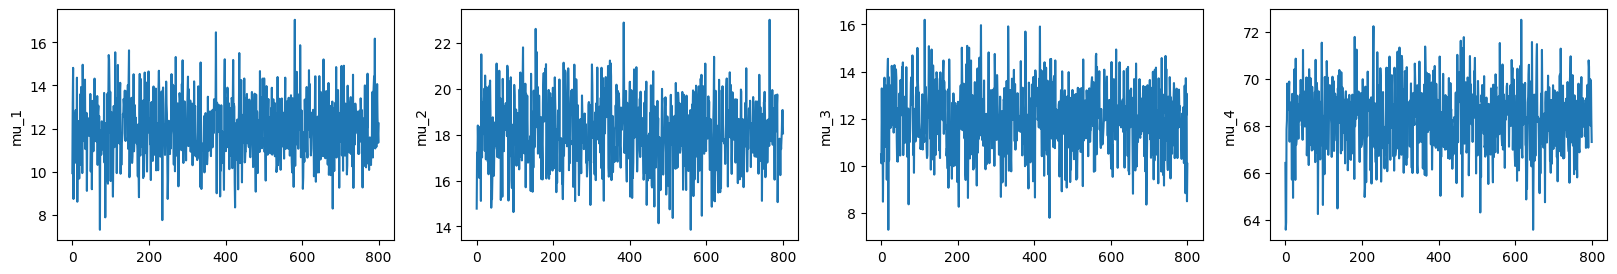

In [50]:
# sample
#  0                           1                2                3     4      5
# [(mu_l,Sigma_l;l=1,2,...,N), (w_l;l=1,...,N), (L_i;i=1,...,n), mu_0, tau_0, alpha]
diag_inst_mu_l = MCMC_Diag()
diag_inst_mu_l.set_mc_samples_from_list([m[0][0] for m in diag_inst.get_specific_dim_samples(0)])
diag_inst_mu_l.set_variable_names(['mu_'+str(l) for l in range(1,trunc_N+1)])
diag_inst_mu_l.show_traceplot((1,4), [0,1,2,3])

Finally, the convergence of $\mu_l$ s seems good.

Let me skip to display traceplots for $\Sigma_l$ and $\tau_0$, the covariance matrices.

## Inference

### Check Goodness of Fit using data points in the dataset

To begin with, let me check the goodness of fit by the conditional distribution of the posterior.
Using the data points, we have in the dataset, by setting the same values of covariates, I will check whether the 95% credible interval can cover the observed ozone level.
Even if we discussed the better way to check the goodness of fit, let me do it in this very basic way here for simplicity.

In [28]:
infer_inst = HW4DensityReg_Infer(data_airquality, diag_inst.MC_sample)
# observations
#     ozone, solar_r, wind, temp
# "1",41, 190, 7.4, 67
# "2",36, 118, 8, 72
# "3",12, 149, 12.6, 74
# "4",18, 313, 11.5, 62
# "7",23, 299, 8.6, 65
# "8",19, 99, 13.8, 59
print(infer_inst.y_given_x_G_mean_quantile(np.array([190, 7.4, 67]))) #target: 41
print(infer_inst.y_given_x_G_mean_quantile(np.array([118, 8, 72]))) #target: 36
print(infer_inst.y_given_x_G_mean_quantile(np.array([149, 12.6, 74]))) #target:12
print(infer_inst.y_given_x_G_mean_quantile(np.array([313, 11.5, 62]))) #target:18
print(infer_inst.y_given_x_G_mean_quantile(np.array([299, 8.6, 65]))) #target:23
print(infer_inst.y_given_x_G_mean_quantile(np.array([99, 13.8, 59]))) #target:19


(31.282030553652827, array([21.74690882, 31.42428039, 40.60996672]))
(19.458867556160687, array([ 6.74943675, 19.05680895, 35.76344875]))
(17.643659795752313, array([ 7.12971504, 17.07928265, 32.16888504]))
(25.287321696335237, array([16.47884877, 25.11971491, 35.234717  ]))
(25.262062520314238, array([16.48209152, 25.0781456 , 34.66324296]))
(25.698360475392317, array([15.23440761, 25.96719557, 35.67286684]))


The console result shows $ozone|covariates=x$'s (mean, [0.025q, 0.5q, 0.975q]) at a 3-dimensional covariate value $x$.

Sadly, the result does not seem very good.
For the first and second data points, the observed ozone levels are slightly outside the upper limit of their 95% credible interval.
For other points, the intervals cover the observed values, but the lengths of the credible intervals are too long.
Mean values and medians are not close to the observed ozone values.

### Posterior joint distribution

Let's see pairwise joint distributions and come back to conditional distributions.

The next three plots are scatterplots of samples generated from the posterior joint distribution of (ozone, solar.R, wind, temp).
I will display pairwisely, i.e. (solar.R, ozone), (wind, ozone), (temp, ozone), in order.

Orange dots are observations in the dataset, and blue points are posterior samples.
Dark blue indicates that more samples were generated around the area.

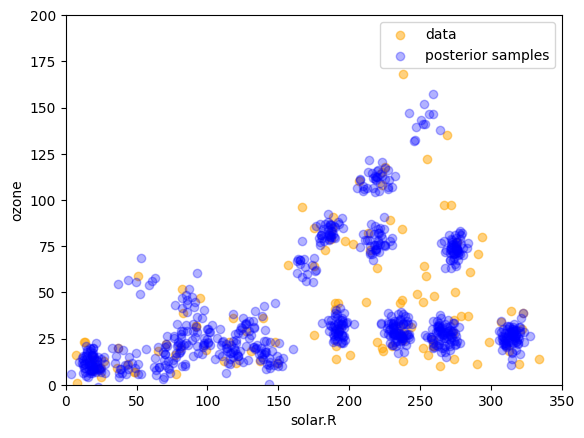

In [55]:
joint_samples = infer_inst.yx_pair_joint_rv_gen_for_plot()
#solar.R
plt.scatter(data_solar_r, data_ozone, alpha=0.5, c='orange', label='data')
plt.scatter(joint_samples[1], joint_samples[0], alpha=0.3, c='blue', label='posterior samples')
plt.xlim(0, 350)
plt.ylim(0, 200)
plt.xlabel("solar.R")
plt.ylabel("ozone")
plt.legend()
plt.show()


The joint samples are clustered too much and narrowly for the (ozone, solar.R) pair. 
This plot also indicates that the posterior is overfitted to the data.
From this plot, we can find how to remedy this; we should raise the variance in the fixed $\Sigma_l$'s (2,2) elements.

Note that this plot shows well how the density regression works despite the absurd results.
We are fitting joint distribution using clusters in the four-dimensional space. :D

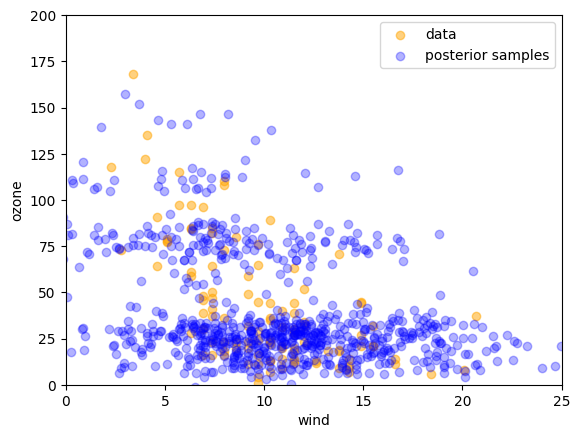

In [56]:
#wind
plt.scatter(data_wind, data_ozone, alpha=0.5, c='orange', label='data')
plt.scatter(joint_samples[2], joint_samples[0], alpha=0.3, c='blue', label='posterior samples')
plt.xlim(0, 25)
plt.ylim(0, 200)
plt.xlabel("wind")
plt.ylabel("ozone")
plt.legend()
plt.show()


For the (ozone, wind) pair, the joint samples are clustered too less.
For the wind direction, the posterior variance is too high. 
To improve this poor fit, we may set the fixed $\Sigma_l$'s (3,3) elements to be smaller than now.

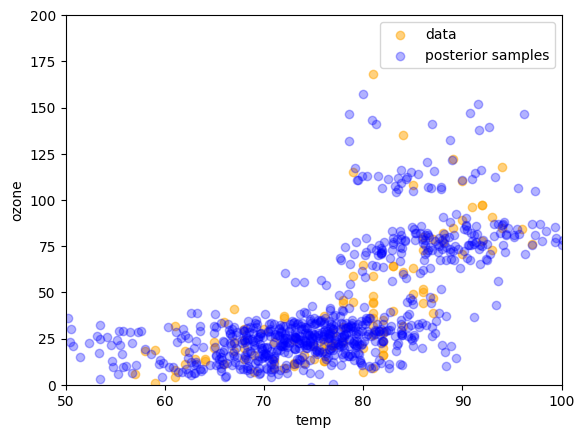

In [57]:
#temp
plt.scatter(data_temp, data_ozone, alpha=0.5, c='orange', label='data')
plt.scatter(joint_samples[3], joint_samples[0], alpha=0.3, c='blue', label='posterior samples')
plt.xlim(50, 100)
plt.ylim(0, 200)
plt.xlabel("temp")
plt.ylabel("ozone")
plt.legend()
plt.show()    

The joint samples seem good except for the left-bottom part for the (ozone, temp) pair.
We can see a cluster around (temp, ozone)=(55, 25) where the area has no data point.
This extrapolation is disconcerting. 
Perhaps this is because DP cannot yield $\mu_l$ around (60,20) in the MCMC chain iterations.
It may get better if I run the chain longer.

### Posterior conditional distribution

Using the properties of multivariate normal distributions, we can construct conditional distributions.
It's possible that we can build $ozone|covariate$ after marginalizing other covariates out. 
Still, here, I will build $ozone|solar.R, wind, temp$ and explore the relationship of (solar.R, ozone), (wind, ozone), (temp, ozone) pairwisely by fixing other covariates levels in their sample mean values.

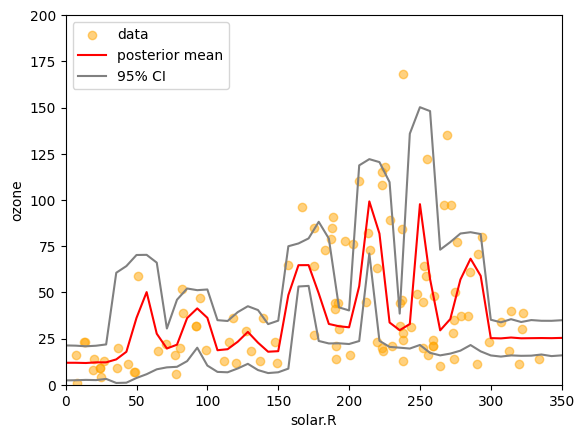

In [58]:
# > colMeans(without_na_airquality)
#      Ozone    Solar.R       Wind       Temp      Month        Day 
#  42.099099 184.801802   9.939640  77.792793   7.216216  15.945946
    
# ozone vs solar_R
solar_r_grid = np.linspace(0, 350, 50)
y_vs_solar_r_lower = []
y_vs_solar_r_mean = []
y_vs_solar_r_upper = []
for solar_r in solar_r_grid:
    quant = infer_inst.y_given_x_G_mean_quantile(np.array([solar_r, 10, 78]))
    y_vs_solar_r_mean.append(quant[0])
    y_vs_solar_r_lower.append(quant[1][0])
    y_vs_solar_r_upper.append(quant[1][2])
plt.scatter(data_solar_r, data_ozone, alpha=0.5, c='orange', label='data')
plt.plot(solar_r_grid, y_vs_solar_r_mean, c='red', label='posterior mean')
plt.plot(solar_r_grid, y_vs_solar_r_lower, c='grey', label='95% CI')
plt.plot(solar_r_grid, y_vs_solar_r_upper, c='grey')
plt.xlim(0, 350)
plt.ylim(0, 200)
plt.xlabel("solar.R")
plt.ylabel("ozone")
plt.legend()
plt.show()


For the (ozone, solar.R) pair, the posterior conditional distribution is overfitted to the data, like the joint distribution.
It looks flexible anyway, but it may not be the optimal result for the prediction purpose.

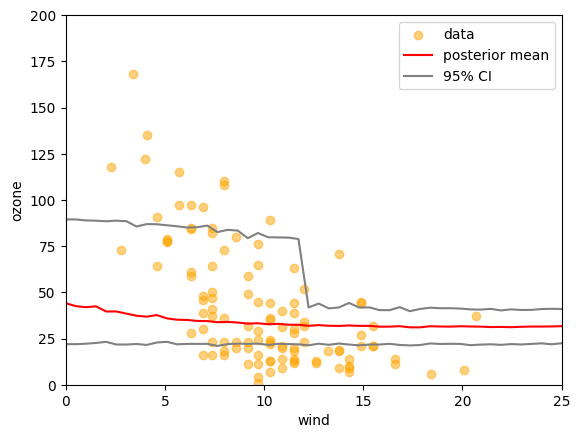

In [59]:
# ozone vs Wind
wind_grid = np.linspace(0, 25, 50)
y_vs_wind_lower = []
y_vs_wind_mean = []
y_vs_wind_upper = []
for wind in wind_grid:
    quant = infer_inst.y_given_x_G_mean_quantile(np.array([185, wind, 78]))
    y_vs_wind_mean.append(quant[0])
    y_vs_wind_lower.append(quant[1][0])
    y_vs_wind_upper.append(quant[1][2])
plt.scatter(data_wind, data_ozone, alpha=0.5, c='orange', label='data')
plt.plot(wind_grid, y_vs_wind_mean, c='red', label='posterior mean')
plt.plot(wind_grid, y_vs_wind_lower, c='grey', label='95% CI')
plt.plot(wind_grid, y_vs_wind_upper, c='grey')
plt.xlim(0, 25)
plt.ylim(0, 200)
plt.xlabel("wind")
plt.ylabel("ozone")
plt.legend()
plt.show()
    

For the (ozone, wind) pair, the posterior conditional distribution is too under-fitted to the data, like the joint distribution.
It cannot capture the negative relationship very well, even if the 95% credible intervals' upper limits follow the relationship very crudely.
We cannot conclude this fitting is good.

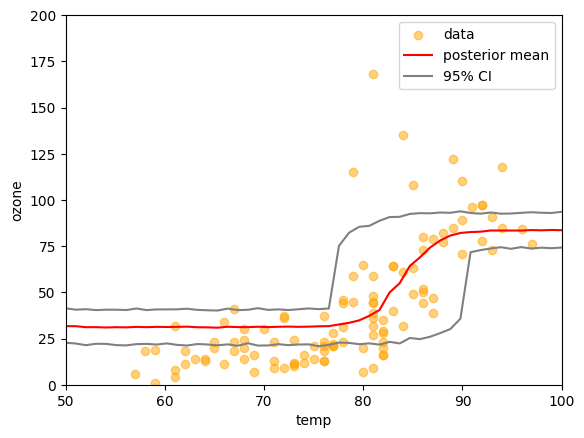

In [60]:
# ozone vs Temp
temp_grid = np.linspace(50, 100, 50)
y_vs_temp_lower = []
y_vs_temp_mean = []
y_vs_temp_upper = []
for temp in temp_grid:
    quant = infer_inst.y_given_x_G_mean_quantile(np.array([185, 10, temp]))
    y_vs_temp_mean.append(quant[0])
    y_vs_temp_lower.append(quant[1][0])
    y_vs_temp_upper.append(quant[1][2])
plt.scatter(data_temp, data_ozone, alpha=0.5, c='orange', label='data')
plt.plot(temp_grid, y_vs_temp_mean, c='red', label='posterior mean')
plt.plot(temp_grid, y_vs_temp_lower, c='grey', label='95% CI')
plt.plot(temp_grid, y_vs_temp_upper, c='grey')
plt.xlim(50, 100)
plt.ylim(0, 200)
plt.xlabel("temp")
plt.ylabel("ozone")
plt.legend()
plt.show()

For the (ozone, wind) pair, the posterior conditional distribution catches the general trend but misbehaves in the left tail, as seen in the joint distribution.
The tail does not vanish at the low-temperature area with a weird extrapolation.

## Discussion

I comment more about $\Sigma_l$ here.

- I could not find how to deal with $\Sigma_l$ inflation under the model allowing covariance mixing through DP mixture. Inverse Wishart distribution in $G_0$(one of the DP parameters) may not be a good choice because it has only two parameters, so it cannot control realization in more detail and sometimes generates numerically unfavorable realizations in a specific context. We may be able to consider many other distributions and priors for the semi-positive matrix space. For example, we can be inspired by Bayesian graphical models. But this alternative approach makes our model much more challenging to implement.
- If we set $\Sigma_l$ manually, tuning its elements is a tricky problem because the posterior fit is sensitive to the $\Sigma_l$. We can try tuning diagonal elements by trial-and-error watching joint distribution, but tuning off-diagonal elements is too difficult because it is sometimes unintuitive. In addition, if we think the fixed $\Sigma_l$ as our point-mass prior with probability 1, this tunning can be regarded as 'prior cheating' because the procedure requires lots of information about the given dataset. That's why I stopped doing more.
- As a compromise between the above two models, we can just put a common $\Sigma$ for all $\Sigma_l$ and put a prior on it, as we did in `HW3`. Then we can avoid the tuning $\Sigma_l$ directly and too much inflated $\Sigma_l$ by selecting a powerful hyperparameter for $\Sigma$ in favor of the identity matrix. However, I still expect some level of overblown $\Sigma$ problem because I saw it in the context of the univariate case at HW3, albeit less intense. We need some hyperparameter tunning.

An cartesian product setting (with independent Normal and inverse Wishart) on $G_0$ may not be optimal as well. We can put an additional dependency on the model that can help posterior fitting.

A marginalized sampler may suffer less from this problem than a block-Gibbs sampler, but I'm not sure.

One possible (and very practical) remedy is normalizing all variables by their sample standard deviation before doing density regression.
But I did not take this approach because I (partly) wanted to see how density regression works outside a well-controlled setting.

Another treatment may be finer tuning for hyperparameters for $\alpha$ and $N$, the truncation level of the stick-breaking process.
It will affect how each data point is clustered by controlling the number of clusters and how minutely the clustering is.